**Function for windowing**

In [14]:
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
        if type(x) == dicom.multival.MultiValue:
            return int(x[0])
        else:
            return int(x)
def get_windowing(data):
        dicom_fields = [data[('0028','1050')].value, #window center
                        data[('0028','1051')].value, #window width
                        data[('0028','1052')].value, #intercept
                        data[('0028','1053')].value] #slope
        return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

        img = (img*slope +intercept)
        img_min = window_center - window_width//2
        img_max = window_center + window_width//2
        img[img<img_min] = img_min
        img[img>img_max] = img_max

        if rescale:
            # Extra rescaling to 0-1, not in the original notebook
            img = (img - img_min) / (img_max - img_min)

        return img


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch
from torchvision import transforms
import torchvision.models as models
import pydicom as dicom
import copy

train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(896),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(896),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class BrainCTDataset_ResNet(Dataset):
    
    def __init__(self, csv_file, root_dir,transform=None,get_windowing=get_windowing,
                 get_first_of_dicom_field_as_int=get_first_of_dicom_field_as_int,
                 window_image=window_image):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.get_windowing=get_windowing
        self.transform = transform
        self.window_image=window_image
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        

        data=self.data_frame
        
        
        data=self.data_frame

        img_name = '/scratch/hg1580/rsna-intracranial-hemorrhage-detection/stage_2_train/'+data.iloc[idx, 2]
        
        image = dicom.read_file(img_name)
        window_center , window_width, intercept, slope = get_windowing(image)

        img2 = window_image(image.pixel_array, 40, 80, intercept, slope)  
        img3 = window_image(image.pixel_array, 80, 200, intercept, slope)
        img4 = window_image(image.pixel_array, 600, 2800, intercept, slope)
        image = torch.Tensor(np.array([img2, img3, img4,]))
            
        image_class = data.iloc[idx, -1]
        

        if self.transform:
            image = self.transform(image)
        
        sample = {'x': image, 'y': image_class}
            
        return sample

**Model ResNet18**

In [6]:
if torch.cuda.is_available:
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

resnet18=models.resnet18()

fc_in_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(fc_in_features, 2)
res=resnet18.to(device)

In [25]:
import time
from PIL import Image
train_df_path = '/scratch/hg1580/kaggle/stage1_train.csv'
val_df_path = '/scratch/hg1580/kaggle/stage1_valid.csv'
test_df_path='/scratch/hg1580/kaggle/stage1_test.csv'
transformed_dataset = {'train': BrainCTDataset_ResNet(train_df_path,'./HW2/images/'), \
                       'validate':BrainCTDataset_ResNet(val_df_path,'./HW2/images/'), \
                      'test': BrainCTDataset_ResNet(test_df_path,'./HW2/images/')}
bs = 10
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs, shuffle=True, num_workers=0) \
              for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}
optimizer = torch.optim.Adam(res.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [17]:

def train_model(model, dataloader, optimizer, loss_fn, num_epochs = 10, verbose = False, scheduler=None):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data['x'].to(device,dtype=torch.float)
                label = data['y'].to(device,dtype=torch.long)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                if scheduler:
                    scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict

In [18]:
model,acc_dict,loss_dict=train_model(res,dataloader,optimizer,criterion,num_epochs=10,verbose=True)


Epoch: 0/9
----------
Phase:train, epoch loss: 0.5321 Acc: 0.7189
Phase:validate, epoch loss: 0.6220 Acc: 0.7171
Epoch: 1/9
----------
Phase:train, epoch loss: 0.3940 Acc: 0.8186
Phase:validate, epoch loss: 0.2391 Acc: 0.9189
Epoch: 2/9
----------
Phase:train, epoch loss: 0.3430 Acc: 0.8480
Phase:validate, epoch loss: 0.2767 Acc: 0.8952
Epoch: 3/9
----------
Phase:train, epoch loss: 0.3090 Acc: 0.8656
Phase:validate, epoch loss: 0.2224 Acc: 0.9208
Epoch: 4/9
----------
Phase:train, epoch loss: 0.2838 Acc: 0.8785
Phase:validate, epoch loss: 0.2891 Acc: 0.8901
Epoch: 5/9
----------
Phase:train, epoch loss: 0.2571 Acc: 0.8912
Phase:validate, epoch loss: 0.2018 Acc: 0.9300
Epoch: 6/9
----------
Phase:train, epoch loss: 0.2333 Acc: 0.9026
Phase:validate, epoch loss: 0.2192 Acc: 0.9225
Epoch: 7/9
----------
Phase:train, epoch loss: 0.2059 Acc: 0.9156
Phase:validate, epoch loss: 0.3350 Acc: 0.8763
Epoch: 8/9
----------
Phase:train, epoch loss: 0.1783 Acc: 0.9268
Phase:validate, epoch loss: 0.

In [19]:
torch.save(model.state_dict(),'/scratch/hg1580/kaggle/resnet_best.pickle')

In [20]:
torch.save((acc_dict,loss_dict),'/scratch/hg1580/kaggle/resnet_acc_loss.pickle')



In [28]:
with torch.no_grad():
                running_correct = 0
                running_loss = 0
                running_total = 0
                soft=nn.Softmax(dim=1)
                probs=[]
                truth=[]

                for data in dataloader['test']:
                    model.eval()
                    optimizer.zero_grad()
                    image = data['x'].to(device,dtype=torch.float)
                    label = data['y'].to(device,dtype=torch.long)
                    output = model(image)
                    prob=soft(output).T[1]
                    probs+=prob.to('cpu').tolist()
                    truth +=label.to('cpu').tolist()
                    loss = criterion(output, label)
                    _, preds = torch.max(output, dim = 1)
                    num_imgs = image.size()[0]
                    running_correct += torch.sum(preds ==label).item()
                    running_loss += loss.item()*num_imgs
                    running_total += num_imgs
                    
                epoch_acc = float(running_correct/running_total)
                epoch_loss = float(running_loss/running_total)

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model 
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [32]:
def plotUnivariateROC(preds, truth, label_string):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)

    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    c = (np.random.rand(), np.random.rand(), np.random.rand())

    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

0.9292031956546906

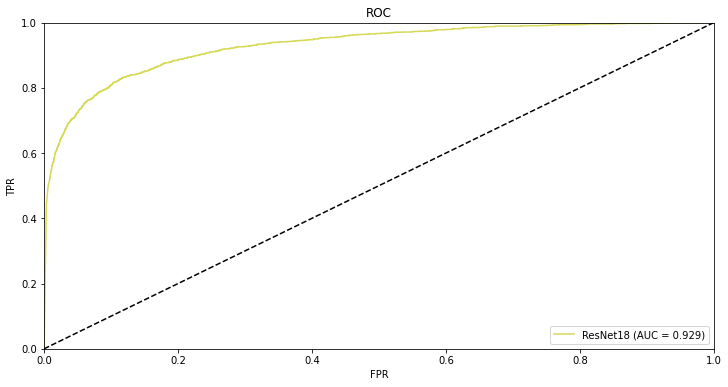

In [33]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plotUnivariateROC(probs, truth, 'ResNet18')